# Machine Learning Foundation

## Course 6, Part f: SARIMA and Prophet DEMO

# Section 6: Predicting with [Facebook](https://facebookincubator.github.io/prophet/) [Prophet](https://research.fb.com/prophet-forecasting-at-scale/)

From site:

> Today Facebook is open sourcing Prophet, a forecasting tool available in Python and R. The idea is that producing high quality forecasts is not an easy problem for either machines or for most analysts. The models revolves around two main observations in the practice of creating a variety of business forecasts:
- Completely automatic forecasting techniques can be brittle and they are often too inflexible to incorporate useful assumptions or heuristics.
- Analysts who can produce high quality forecasts are quite rare because forecasting is a specialized data science skill requiring substantial experience.

Prophet is an general additive model that includes a number of highly advanced, intelligent [forecasting methods](http://andrewgelman.com/2017/03/01/facebooks-prophet-uses-stan/), including [changepoint analysis](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=2&ved=0ahUKEwjpwM_JhsbVAhWNxIMKHSWqD6kQFgguMAE&url=http%3A%2F%2Fwww.variation.com%2Fcpa%2Ftech%2Fchangepoint.html&usg=AFQjCNFK6wbwWuBCixZJHu03LkABXL3UHA):


_y = g(t) + s(t) + h(t) + $\epsilon_t$_

Here g(t) is the trend function which models non-periodic changes in the value of the time series, s(t) represents periodic changes (e.g., weekly and yearly seasonality), and h(t) represents the effects of holidays which occur on potentially irregular schedules over
one or more days

- For trend, a piecewise linear or logistic growth curve trend is used. 
    - Prophet automatically detects changes in trends by selecting changepoints from the data.
- For seasonalities, different seasonality components are modeled using Fourier series.
- One can either use fb provided list or incorporate their own holidays into model.


Prophet was originally optimized with the business forecast tasks encountered at Facebook in mind, which typically have any of the following characteristics:

- Hourly, daily, or weekly observations with at least a few months (preferably a year) of history
- Strong multiple “human-scale” seasonalities: day of week and time of year
- Important holidays that occur at irregular intervals that are known in advance
- A reasonable number of missing observations or large outliers
- Historical trend changes, for instance due to product launches or logging changes
- Trends that are non-linear growth curves, where a trend hits a natural limit or saturates


[Technical details behind prophet](https://facebookincubator.github.io/prophet/static/prophet_paper_20170113.pdf): built around a generalized additive model (GAM)

In [79]:
# read daily page views for the Wikipedia page for Peyton Manning; scraped into hosted CSV
# conda install -c conda-forge fbprophet (to install)
from fbprophet import Prophet
plt.rcParams['figure.figsize'] = [14, 4]

data_path = 'https://raw.githubusercontent.com/PinkWink/DataScience/master/data/07.%20example_wp_peyton_manning.csv'
peyton = pd.read_csv(data_path)

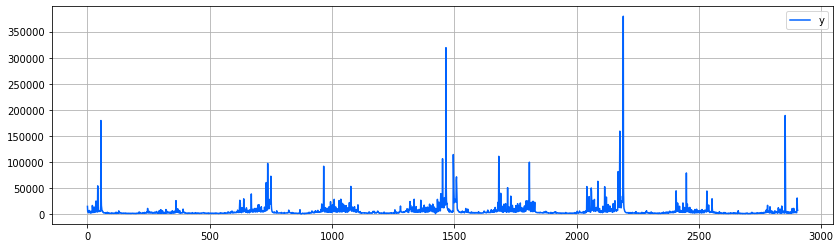

In [80]:
# plot data
peyton.plot()
plt.grid();

In [81]:
# log data due to spikes
# dataframe must have ds column with type datetime and y column which is time series we are trying to predict
peyton['y'] = np.log(peyton['y'])
peyton.head()

,ds,y
0,2007-12-10,9.590761
1,2007-12-11,8.519590
2,2007-12-12,8.183677
3,2007-12-13,8.072467
4,2007-12-14,7.893572


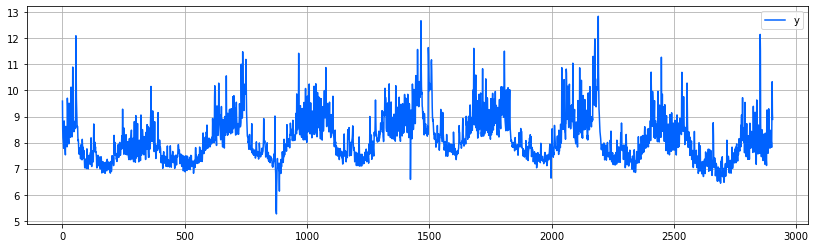

In [82]:
# plot log
peyton.plot()
plt.grid();

In [83]:
# fit model
m = Prophet()
m.fit(peyton)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [84]:
peyton.head()

,ds,y
0,2007-12-10,9.590761
1,2007-12-11,8.519590
2,2007-12-12,8.183677
3,2007-12-13,8.072467
4,2007-12-14,7.893572


In [85]:
# forecast 365 days into future
# prophet requires a blank dataframe to input predictions
# will also provide blank set for dates within dataset to allow for fit
future = m.make_future_dataframe(periods=365)
print(future.head())
print(future.tail())

          ds
0 2007-12-10
1 2007-12-11
2 2007-12-12
3 2007-12-13
4 2007-12-14
             ds
3265 2017-01-15
3266 2017-01-16
3267 2017-01-17
3268 2017-01-18
3269 2017-01-19


In [86]:
# populate forecast
forecast = m.predict(future)
print(forecast.columns)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'additive_terms', 'additive_terms_lower', 'additive_terms_upper',
       'weekly', 'weekly_lower', 'weekly_upper', 'yearly', 'yearly_lower',
       'yearly_upper', 'multiplicative_terms', 'multiplicative_terms_lower',
       'multiplicative_terms_upper', 'yhat'],
      dtype='object')


,ds,yhat,yhat_lower,yhat_upper
3265,2017-01-15,8.208171,7.503198,8.922039
3266,2017-01-16,8.533159,7.753492,9.214067
3267,2017-01-17,8.320549,7.631910,9.061524
3268,2017-01-18,8.153184,7.425827,8.886352
3269,2017-01-19,8.165106,7.441329,8.879306


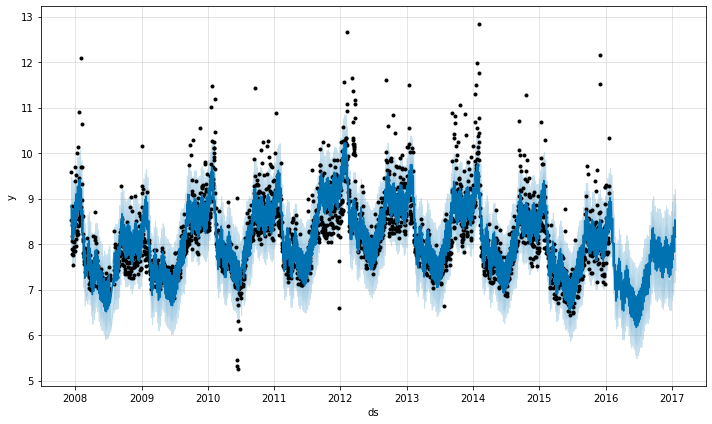

In [87]:
# plot forecast
m.plot(forecast);

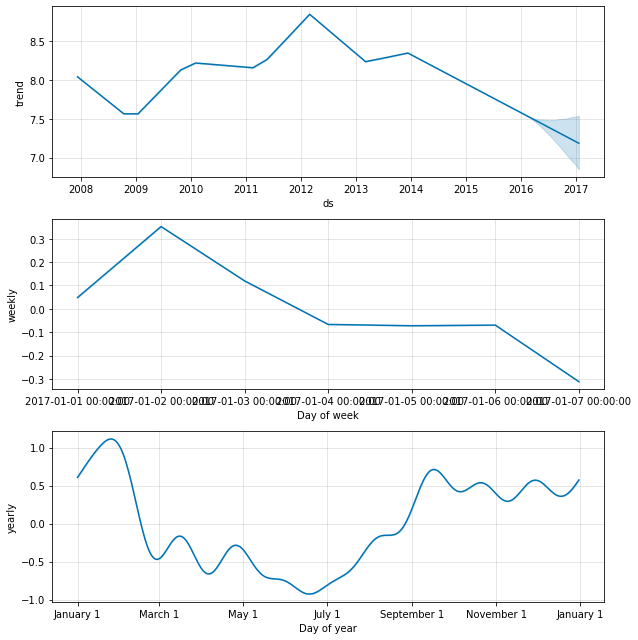

In [88]:
# plot individual components of forecast: trend, weekly/yearly seasonality,
m.plot_components(forecast);

>We can also add holiday and Superbowl date information to Peyton's forecast, since we hypothesize people will visit his site more often on those dates.

In [89]:
# add holidays 
playoffs = pd.DataFrame({
  'holiday': 'playoff',
  'ds': pd.to_datetime(['2008-01-13', '2009-01-03', '2010-01-16',
                        '2010-01-24', '2010-02-07', '2011-01-08',
                        '2013-01-12', '2014-01-12', '2014-01-19',
                        '2014-02-02', '2015-01-11', '2016-01-17',
                        '2016-01-24', '2016-02-07']),
  'lower_window': 0, # these help us specify spillover into previous and future days which will be treated as own holidays
  'upper_window': 1,
})

superbowls = pd.DataFrame({
  'holiday': 'superbowl',
  'ds': pd.to_datetime(['2010-02-07', '2014-02-02', '2016-02-07']),
  'lower_window': 0,
  'upper_window': 1,
})

holidays = pd.concat((playoffs, superbowls))

In [90]:
holidays.head()

,holiday,ds,lower_window,upper_window
0,playoff,2008-01-13,0,1
1,playoff,2009-01-03,0,1
2,playoff,2010-01-16,0,1
3,playoff,2010-01-24,0,1
4,playoff,2010-02-07,0,1


In [91]:
# fit and predict
m = Prophet(holidays=holidays)
forecast = m.fit(peyton).predict(future)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [92]:
# we can see the effects of various 'holidays' on site visits
forecast[(forecast['playoff'] + forecast['superbowl']).abs() > 0][
        ['ds', 'playoff', 'superbowl']][-10:]

,ds,playoff,superbowl
2190,2014-02-02,1.224221,1.203104
2191,2014-02-03,1.898940,1.459895
2532,2015-01-11,1.224221,0.000000
2533,2015-01-12,1.898940,0.000000
2901,2016-01-17,1.224221,0.000000
2902,2016-01-18,1.898940,0.000000
2908,2016-01-24,1.224221,0.000000
2909,2016-01-25,1.898940,0.000000
2922,2016-02-07,1.224221,1.203104
2923,2016-02-08,1.898940,1.459895


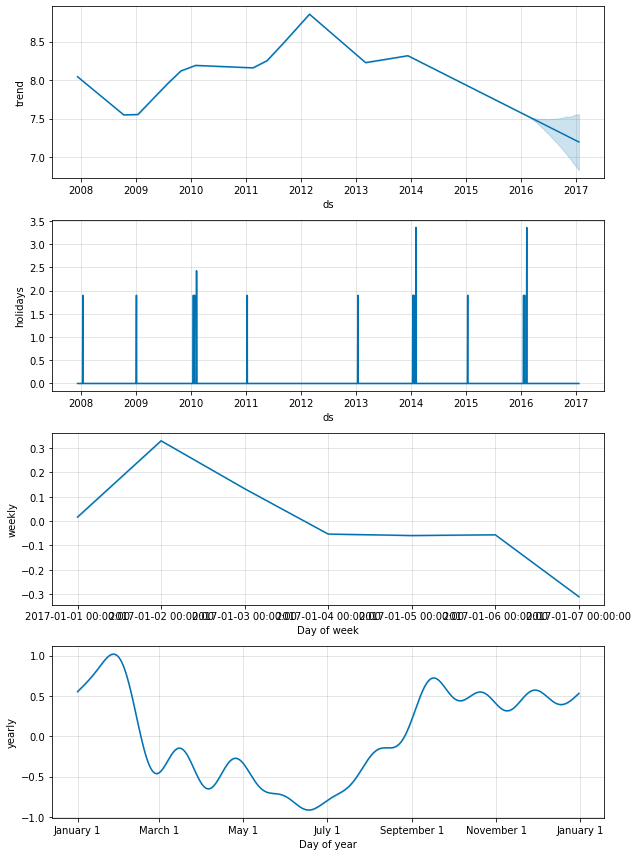

In [93]:
# check the impacts visually
m.plot_components(forecast);

>Peyton won Superbowls XLI (41, 2007) and 50 (2016), while losing XLIV (44, 2010) and XLVIII(48, 2014). We can see these spikes in the holidays chart.

In [94]:
# Add in another seasonality besides yearly, weekly, daily
# fit model
m = Prophet(holidays=holidays,)
m.add_seasonality(name='monthly', period=30.5, fourier_order=5)
m.fit(peyton)


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [95]:
fcst_month = m.predict(future)

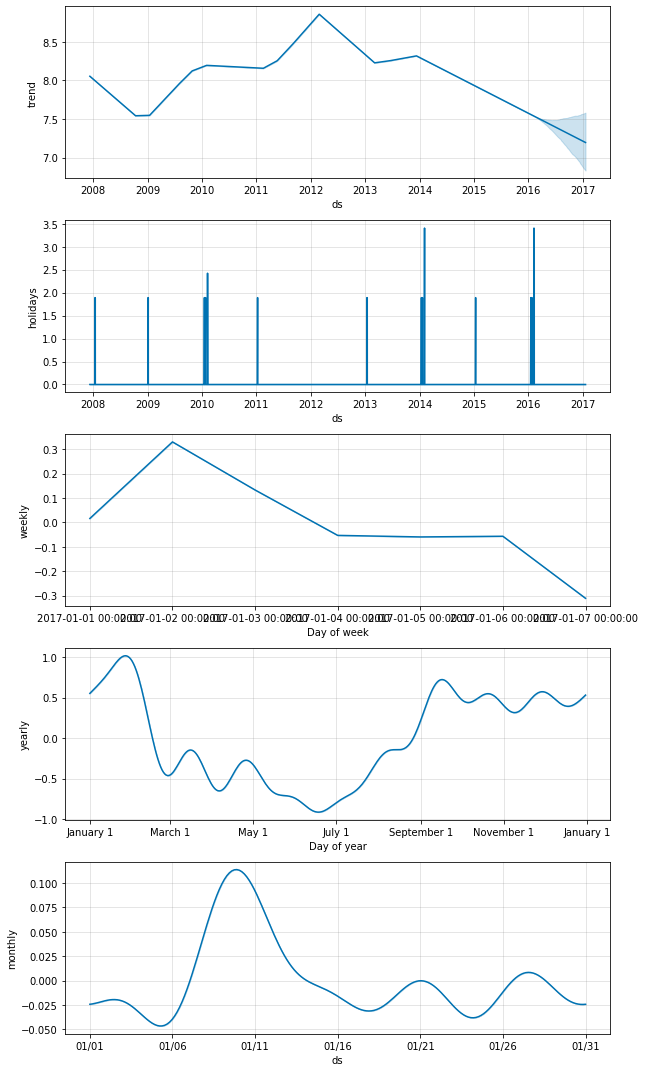

In [96]:
m.plot_components(fcst_month)
plt.show()

# Adding a regressor

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


              ds          y  nfl_sunday
0     2007-12-10   9.590761           0
1     2007-12-11   8.519590           0
2     2007-12-12   8.183677           0
3     2007-12-13   8.072467           0
4     2007-12-14   7.893572           0
...          ...        ...         ...
2900  2016-01-16   7.817223           0
2901  2016-01-17   9.273878           1
2902  2016-01-18  10.333775           0
2903  2016-01-19   9.125871           0
2904  2016-01-20   8.891374           0

[2905 rows x 3 columns]


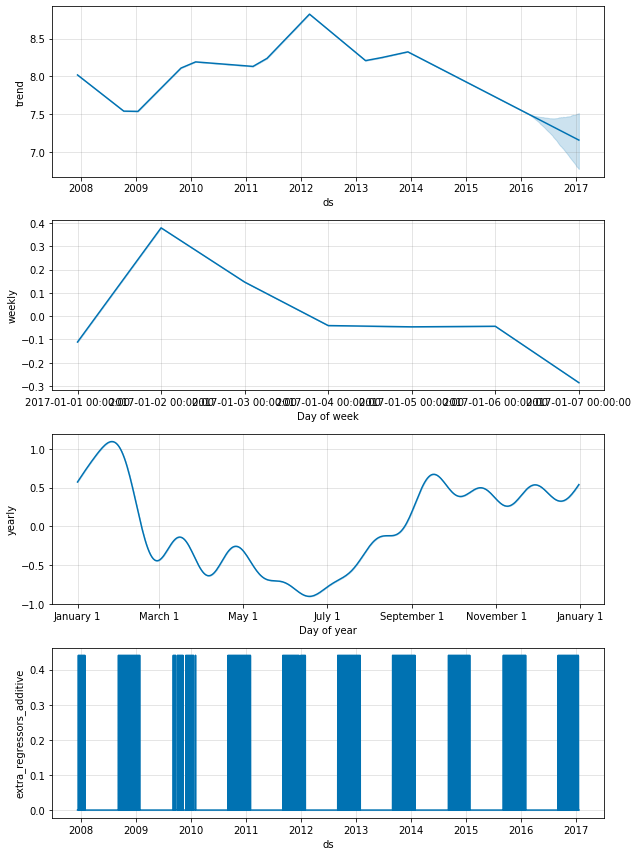

In [97]:
# creating indicator variable for nfl sundays
def nfl_sunday(ds):
    date = pd.to_datetime(ds)
    if date.weekday() == 6 and (date.month > 8 or date.month < 2):
        return 1
    else:
        return 0
    
#adding that to our df
peyton['nfl_sunday'] = peyton['ds'].apply(nfl_sunday)
print(peyton)

m = Prophet()

# must be in the fit df
m.add_regressor('nfl_sunday')
m.fit(peyton)

# regressor must also be available in future df
future['nfl_sunday'] = future['ds'].apply(nfl_sunday)

forecast = m.predict(future)
fig = m.plot_components(forecast)

In [98]:
# These are points where trend has changed
print('originally: ',m.changepoints[:5])
# you can specify changepoints if you want trend to only be allowed at certain points
m_c = Prophet(changepoints=['2014-01-01'])

print('\nnow: ',m_c.changepoints[:5])

originally:  93    2008-03-17
186   2008-06-20
279   2008-10-11
372   2009-01-14
465   2009-04-17
Name: ds, dtype: datetime64[ns]

now:  DatetimeIndex(['2014-01-01'], dtype='datetime64[ns]', freq=None)


# Cross validation with fbprophet
<img src="data/diagnostics_3_0.png">

In [99]:
from fbprophet.diagnostics import cross_validation
#Starting from 730 days in, making a prediction every 180 days, 365 days into the future
df_cv = cross_validation(m, initial='730 days', period='180 days', horizon = '365 days')
df_cv.head()

INFO:fbprophet:Making 11 forecasts with cutoffs between 2010-02-15 00:00:00 and 2015-01-20 00:00:00


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2010-02-16,8.998933,8.532879,9.482757,8.242493,2010-02-15
1,2010-02-17,8.764575,8.258785,9.284304,8.008033,2010-02-15
2,2010-02-18,8.649843,8.143984,9.148289,8.045268,2010-02-15
3,2010-02-19,8.570880,8.091072,9.030213,7.928766,2010-02-15
4,2010-02-20,8.313209,7.839553,8.817683,7.745003,2010-02-15


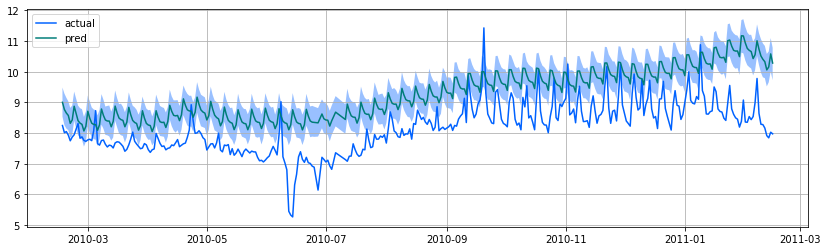

In [100]:
# Just looking at data from first cutoff
first_cut = df_cv[df_cv.cutoff == datetime(2010,2,15)]
plt.plot(first_cut.ds,first_cut.y,label='actual')
plt.plot(first_cut.ds,first_cut.yhat,label = 'pred')
plt.fill_between(first_cut.ds,first_cut.yhat_lower,first_cut.yhat_upper,alpha=0.4)
plt.grid()
plt.legend()

In [101]:
from fbprophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p.head()

,horizon,mse,rmse,mae,mape,coverage
0,37 days,0.494728,0.703369,0.506860,0.058717,0.666514
1,38 days,0.499801,0.706966,0.510718,0.059151,0.665372
2,39 days,0.522379,0.722758,0.517344,0.059815,0.662631
3,40 days,0.529516,0.727679,0.519364,0.060029,0.661261
4,41 days,0.534146,0.730853,0.518587,0.059902,0.668799


### Predicting CO2

In [102]:
# load data
co2 = pd.read_csv('./co2-ppm-mauna-loa-19651980.csv', 
                  header = 0,
                  names = ['idx', 'co2'],
                  skipfooter = 2)
co2 = co2.drop('idx', 1)

# recast co2 col to float
co2['co2'] = pd.to_numeric(co2['co2'])
co2.drop(labels=0, inplace=True)

# set index
index = pd.date_range('1/1/1965', periods=191, freq='M')
co2.index = index

In [103]:
# load co2 data, rename headers, and check
# data = sm.datasets.co2.load_pandas()
# co2 = data.data

co2['ds'] = co2.index
co2.rename(columns={'co2': 'y'}, inplace=True)

co2.tail()

,y,ds
1980-07-31,337.19,1980-07-31
1980-08-31,335.49,1980-08-31
1980-09-30,336.63,1980-09-30
1980-10-31,337.74,1980-10-31
1980-11-30,338.36,1980-11-30


In [104]:
# fit model
model = Prophet()
model.fit(co2);

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [105]:
# forecast 15 years into future
future = model.make_future_dataframe(periods=120, freq='M', include_history=True)
future.tail()

#future = model.make_future_dataframe(periods=365*15)
#future.tail()

,ds
306,1990-07-31
307,1990-08-31
308,1990-09-30
309,1990-10-31
310,1990-11-30


In [106]:
# populate forecast
forecast = model.predict(future)
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
306,1990-07-31,354.924971,335.607648,370.380483,336.769191,371.471783,-1.117225,-1.117225,-1.117225,-1.117225,-1.117225,-1.117225,0.0,0.0,0.0,353.807746
307,1990-08-31,355.063263,333.919260,368.933589,336.610682,371.921462,-2.908550,-2.908550,-2.908550,-2.908550,-2.908550,-2.908550,0.0,0.0,0.0,352.154712
308,1990-09-30,355.197093,333.431875,369.218141,336.460935,372.322623,-3.146657,-3.146657,-3.146657,-3.146657,-3.146657,-3.146657,0.0,0.0,0.0,352.050436
309,1990-10-31,355.335385,334.254718,370.809356,336.313187,372.623899,-2.000587,-2.000587,-2.000587,-2.000587,-2.000587,-2.000587,0.0,0.0,0.0,353.334798
310,1990-11-30,355.469215,335.230407,372.129528,336.179776,372.967186,-0.940856,-0.940856,-0.940856,-0.940856,-0.940856,-0.940856,0.0,0.0,0.0,354.528359


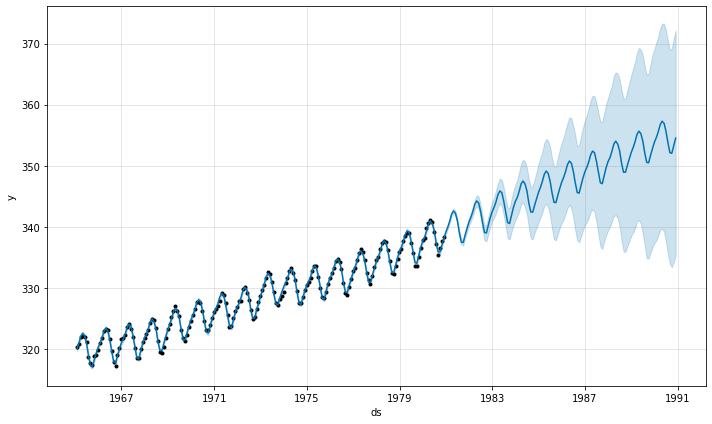

In [107]:
model.plot(forecast);

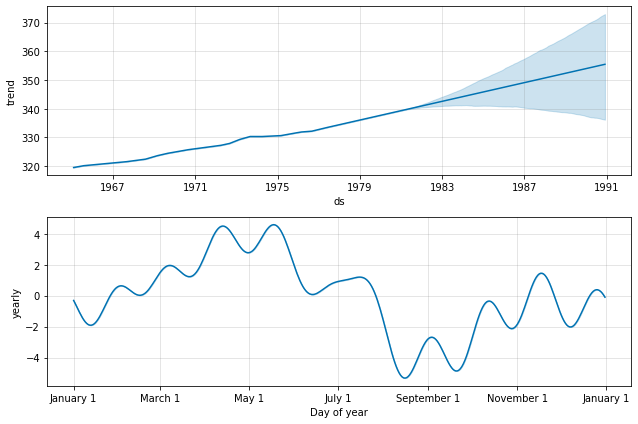

In [108]:
# plot individual components of forecast: trend, weekly/yearly seasonality,
model.plot_components(forecast);

# Things to look into adjusting

In [109]:
# Decreasted drastically from defaults
changepoint_prior_scale = 0.05
seasonality_prior_scale = 0.00001

growth='logistic'

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


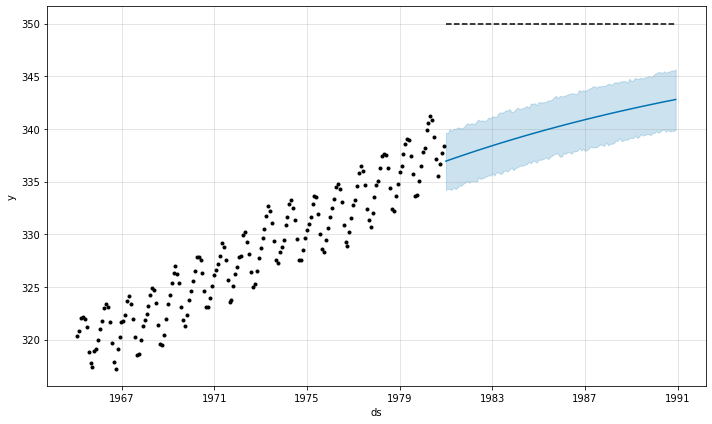

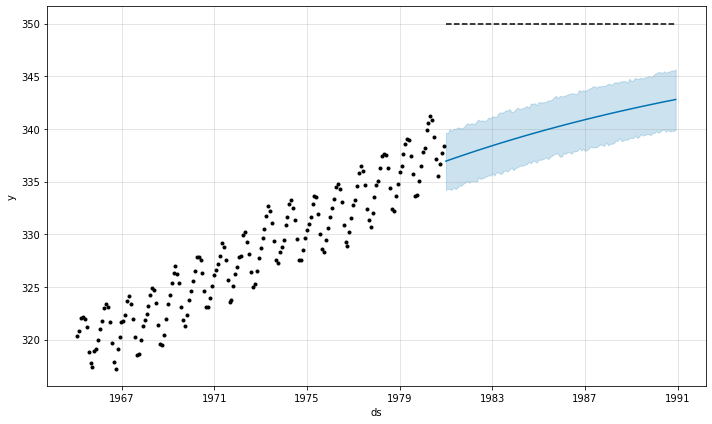

In [110]:
# we can add a cap to limit our theoretical growth if we are using logistic growth
co2['cap'] = 350
m = Prophet(growth=growth, #weekly_seasonality=10000,
            
            seasonality_prior_scale=seasonality_prior_scale,
            changepoint_prior_scale=changepoint_prior_scale)
m.fit(co2);

# forecast 15 years into future with cap of 380
future = m.make_future_dataframe(periods=120,freq='M', include_history=False)
future['cap'] = 350

forecast = m.predict(future)
m.plot(forecast)

# Exercise
* Create prediction using hourly data of PM_Dongsi for last day half of december of 2015
    * Note you will have to use what we first learned to convert the year, month, day, hour columns to datetime object
* Plot daily and weekly seasonality of forecast

In [111]:
df_Beijing = pd.read_csv('./FiveCitiesPM/Beijing.csv')
df_Beijing.head()

,No,year,month,day,hour,season,PM_Dongsi,PM_Dongsihuan,PM_Nongzhanguan,PM_US Post,DEWP,HUMI,PRES,TEMP,cbwd,Iws,precipitation,Iprec
0,1,2010,1,1,0,4,NaN,NaN,NaN,NaN,-21.0,43.0,1021.0,-11.0,NW,1.79,0.0,0.0
1,2,2010,1,1,1,4,NaN,NaN,NaN,NaN,-21.0,47.0,1020.0,-12.0,NW,4.92,0.0,0.0
2,3,2010,1,1,2,4,NaN,NaN,NaN,NaN,-21.0,43.0,1019.0,-11.0,NW,6.71,0.0,0.0
3,4,2010,1,1,3,4,NaN,NaN,NaN,NaN,-21.0,55.0,1019.0,-14.0,NW,9.84,0.0,0.0
4,5,2010,1,1,4,4,NaN,NaN,NaN,NaN,-20.0,51.0,1018.0,-12.0,NW,12.97,0.0,0.0


In [112]:
# Instructor solution
# Create a new column that is a datetime object
def make_date(row):
    return datetime(year = row['year'], month = row['month'], day = row['day'], hour = row['hour'])

df_Beijing['date'] = df_Beijing.apply(make_date,axis=1)
# Make index for easy indexing of time values

df_Beijing.set_index('date',inplace=True)
df_Beijing['ds'] = df_Beijing.index

# Only take required fields
df = df_Beijing[["ds",'PM_Dongsi']]
df.rename(columns = {'PM_Dongsi':'y'},inplace=True)

# create a training set and a test set. We are only going to use last month's data to make everything a bit more clear
df_train = df['2015-11']
df_test = df['2015-12':'2015-12-15']
print(df_train.tail())
print(df_test.tail())

                                     ds      y
date                                          
2015-11-30 19:00:00 2015-11-30 19:00:00  685.0
2015-11-30 20:00:00 2015-11-30 20:00:00  685.0
2015-11-30 21:00:00 2015-11-30 21:00:00  638.0
2015-11-30 22:00:00 2015-11-30 22:00:00  548.0
2015-11-30 23:00:00 2015-11-30 23:00:00  490.0
                                     ds    y
date                                        
2015-12-15 19:00:00 2015-12-15 19:00:00  9.0
2015-12-15 20:00:00 2015-12-15 20:00:00  7.0
2015-12-15 21:00:00 2015-12-15 21:00:00  6.0
2015-12-15 22:00:00 2015-12-15 22:00:00  4.0
2015-12-15 23:00:00 2015-12-15 23:00:00  6.0


In [113]:
# fit model
m = Prophet()
m.fit(df_train)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [114]:
future = m.make_future_dataframe(periods = 15*24,freq = 'h') # could also leave default freq of days and do 31 for period
print(future.head())
future.tail()

                   ds
0 2015-11-01 00:00:00
1 2015-11-01 01:00:00
2 2015-11-01 02:00:00
3 2015-11-01 03:00:00
4 2015-11-01 04:00:00


,ds
1075,2015-12-15 19:00:00
1076,2015-12-15 20:00:00
1077,2015-12-15 21:00:00
1078,2015-12-15 22:00:00
1079,2015-12-15 23:00:00


In [115]:
# populate forecast
forecast = m.predict(future)
print(forecast.columns)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'additive_terms', 'additive_terms_lower', 'additive_terms_upper',
       'daily', 'daily_lower', 'daily_upper', 'weekly', 'weekly_lower',
       'weekly_upper', 'multiplicative_terms', 'multiplicative_terms_lower',
       'multiplicative_terms_upper', 'yhat'],
      dtype='object')


,ds,yhat,yhat_lower,yhat_upper
1075,2015-12-15 19:00:00,1361.302132,1073.065506,1634.896592
1076,2015-12-15 20:00:00,1363.598920,1081.769522,1648.047760
1077,2015-12-15 21:00:00,1362.396483,1073.093923,1648.953237
1078,2015-12-15 22:00:00,1359.504008,1076.761574,1646.262377
1079,2015-12-15 23:00:00,1356.114245,1057.776719,1632.299111


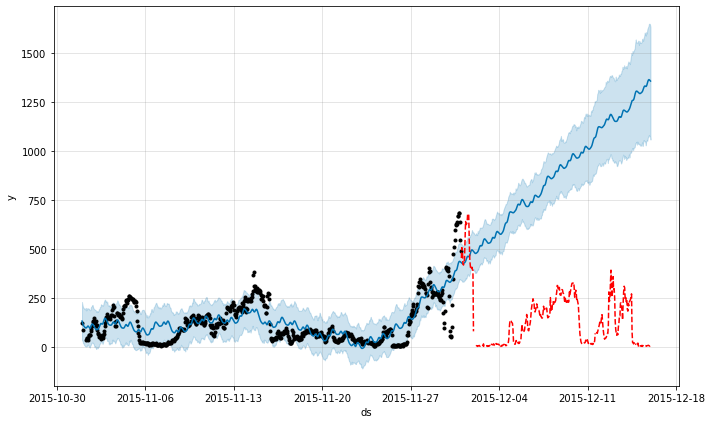

In [116]:
m.plot(forecast)
plt.plot(df_test.y,'r--')

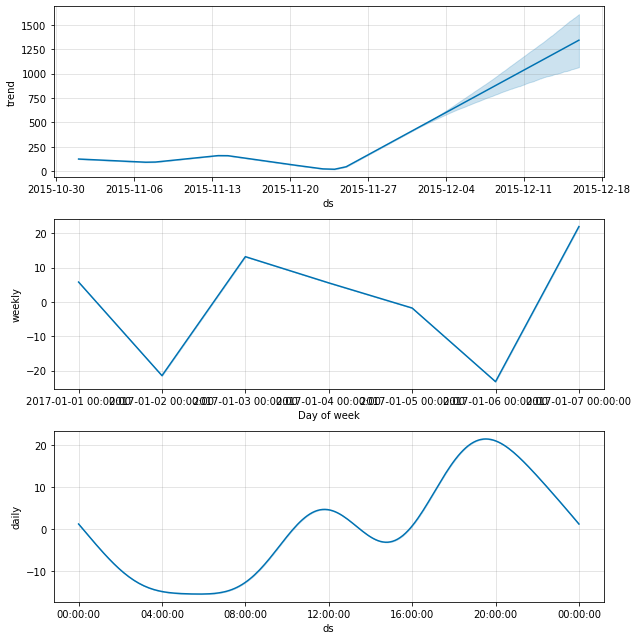

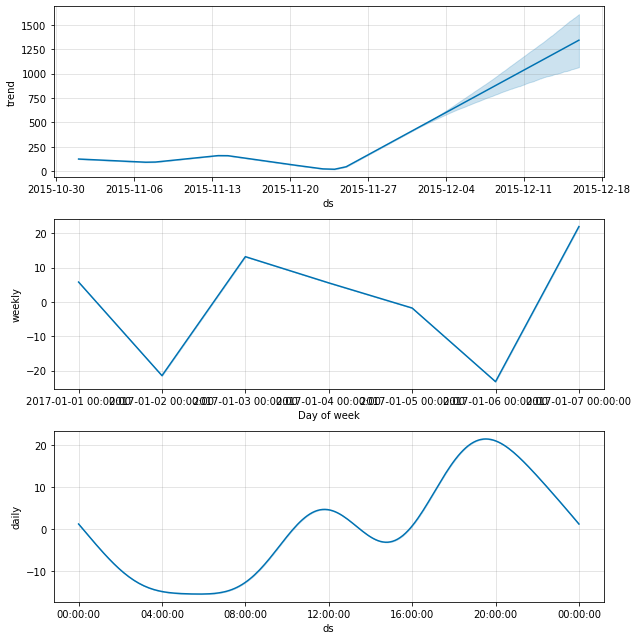

In [117]:
m.plot_components(forecast)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


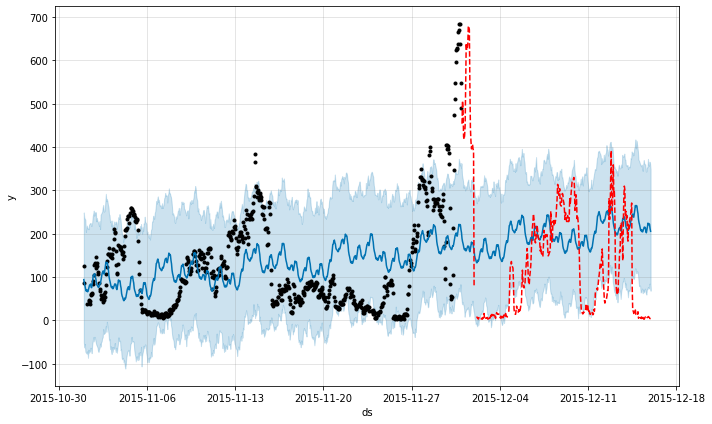

In [118]:
# Decreasted drastically from defaults
changepoint_prior_scale = 0.0005
seasonality_prior_scale = 10


m = Prophet(daily_seasonality=10,
            
            seasonality_prior_scale=seasonality_prior_scale,
            changepoint_prior_scale=changepoint_prior_scale)
m.fit(df_train);


forecast = m.predict(future)
m.plot(forecast)
plt.plot(df_test.y,'r--')

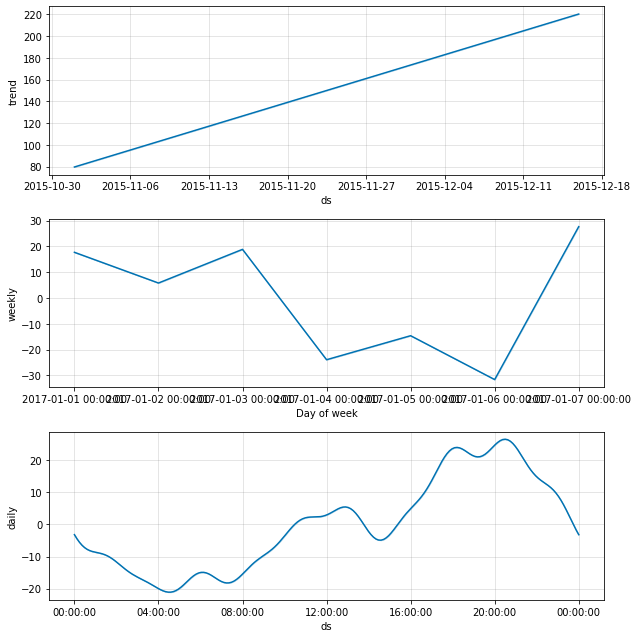

In [119]:
m.plot_components(forecast);

---

# Summary
In this notebook, we have covered: 
1. A practical understanding of Autoregressive Moving Average (ARMA) models.
2. A basic understanding of the Autocorrelation Function (ACF).
3. Insight into choosing the order *q* of MA models.
4. A practical understanding of Autoregressive (AR) models.
5. A basic understanding of the Partial Autocorrelation Function (PACF).
6. Insight into choosing the order *p* of AR models.



---
### Machine Learning Foundation (C) 2020 IBM Corporation